In [97]:
import warnings
warnings.filterwarnings('ignore')

import copy
import datetime
import h5py
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scienceplots
import torch
import torch.nn as nn
import torchvision
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from cv2 import resize
from datetime import datetime
from gc import collect
from os import cpu_count
from scipy.io import savemat, loadmat
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

sys.path.append(f"{os.getcwd()}/ViT architecture/working ViT")
sys.path.append(f"{os.getcwd()}/scripts/")
from VisionTransformer_working import VisionTransformer as Vit_old

sys.path.append(f"{os.getcwd()}/ViT architecture/Architecture tryouts/DPT/")
from VisionTransformer_working_for_DPT import VisionTransformer as Vit
from VisionTransformer_working_for_DPT import VisionTransformer3 as Vit3

In [98]:
random_seed = 2
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [99]:
collect()
torch.cuda.empty_cache()
torch.set_printoptions(precision=6)
device = torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


In [4]:
prob_vit = Vit3(dspl_size=104, 
                patch_size=8, 
                embed_dim=128,
                depth=4,
                n_heads=4,
                mlp_ratio=1.0,
                qkv_bias=False,
                p=0.3,
                attn_p=0.3,
                drop_path=0.).float()

path_to_prob_vit = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/DPT/logs_and_weights/ViT-GNLL_final2023-May-17 23:02:08/ViT-GNLL_final2023-May-17 23:02:08.pth'

prob_vit.load_state_dict(torch.load(path_to_prob_vit, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

<All keys matched successfully>

In [5]:
dspl_test_sets = np.array(h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Test data/resolution_104/allDisplacements.h5', 'r')['dspl'])
dspl_test = np.moveaxis(np.concatenate([dspl_test_sets[i] for i in range(dspl_test_sets.shape[0])], axis=0), 3, 1)[100:110]

trac_test_sets = np.array(h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Test data/resolution_104/allTractions.h5', 'r')['trac'])
trac_test = np.moveaxis(np.concatenate([trac_test_sets[i] for i in range(trac_test_sets.shape[0])], axis=0), 3, 1)[100:110]

In [6]:
Y_test = torch.tensor(trac_test).float()

In [7]:
var = np.mean(np.var(dspl_test, axis=(1,2,3)))
test_sets = {}
noise_sets = {}
for i in range(1, 11):
    test_set = np.zeros(dspl_test.shape)
    noise_set = np.zeros(dspl_test.shape)
    sigma_sq = (i/1000) * var
    for j in range(len(dspl_test)):
        cov = [[sigma_sq, 0],[0, sigma_sq]]
        noise = np.transpose(np.random.default_rng().multivariate_normal(mean=[0, 0], cov=cov, size=(104, 104)))
        test_set[j] = dspl_test[j] + noise
        noise_set[j] = noise
    test_sets[f'{i}'] = test_set
    noise_sets[f'{i}'] = noise_set

In [8]:
def inference_with_dropout(model, inputs):
    model.eval()
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()
    return model(inputs)

In [9]:
def uceloss(errors, uncert, n_bins=15, outlier=0.0, range=None):
    device = errors.device
    if range == None:
        bin_boundaries = torch.linspace(uncert.min().item(), uncert.max().item(), n_bins + 1, device=device)
    else:
        bin_boundaries = torch.linspace(range[0], range[1], n_bins + 1, device=device)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    errors_in_bin_list = []
    avg_uncert_in_bin_list = []
    prop_in_bin_list = []

    uce = torch.zeros(1, device=device)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |uncertainty - error| in each bin
        in_bin = uncert.gt(bin_lower.item()) * uncert.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()  # |Bm| / n
        prop_in_bin_list.append(prop_in_bin)
        if prop_in_bin.item() > outlier:
            errors_in_bin = errors[in_bin].float().mean()  # err()
            avg_uncert_in_bin = uncert[in_bin].mean()  # uncert()
            uce += torch.abs(avg_uncert_in_bin - errors_in_bin) * prop_in_bin

            errors_in_bin_list.append(errors_in_bin)
            avg_uncert_in_bin_list.append(avg_uncert_in_bin)

    err_in_bin = torch.tensor(errors_in_bin_list, device=device)
    avg_uncert_in_bin = torch.tensor(avg_uncert_in_bin_list, device=device)
    prop_in_bin = torch.tensor(prop_in_bin_list, device=device)

    return uce, err_in_bin, avg_uncert_in_bin, prop_in_bin

UCE for test sets

In [10]:
uces = []
errs_in_bin = []
avg_uncerts_in_bin = []
props_in_bin = []

n_forward_passes = 50

for key in tqdm(test_sets.keys()):
    predictions = torch.zeros(10, 50, 4, 104, 104)
    errors = torch.zeros(10, 50, 2, 104, 104)
    for i, sample in enumerate(test_sets[str(key)]):
        for j in range(0, n_forward_passes):
            predictions[i, j, :, :, :] = inference_with_dropout(prob_vit, torch.tensor(sample).float().unsqueeze(0)).detach()
            errors[i, j, :, :, :] = (predictions[i, j, 0:2, :, :] - Y_test[i, 0:2]) ** 2
    errors = torch.mean(errors, dim=1)
    predicted_mean = torch.mean(predictions[:, :, 0:2, :, :], dim=1)
    var = torch.mean(predictions[:, :, 0:2, :, :] ** 2 + predictions[:, :, 2:, :, :], dim=1) - predicted_mean ** 2
    uce, err_in_bin, avg_uncert_in_bin, prop_in_bin = uceloss(errors, var)
    uces.append(uce)
    errs_in_bin.append(err_in_bin)
    avg_uncerts_in_bin.append(avg_uncert_in_bin)
    props_in_bin.append(prop_in_bin)

100%|████████████████████████████████████████████████████████████████| 10/10 [01:08<00:00,  6.81s/it]


In [11]:
uces

[tensor([0.000146]),
 tensor([0.000150]),
 tensor([0.000149]),
 tensor([0.000148]),
 tensor([0.000150]),
 tensor([0.000149]),
 tensor([0.000150]),
 tensor([0.000151]),
 tensor([0.000148]),
 tensor([0.000147])]

In [14]:
def plot_uncert(err, sigma, freq_in_bin=None, outlier_freq=0.0, i=0, uce=0):
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)
    plt.style.use(['science', 'grid', 'muted'])
    if freq_in_bin is not None:
        freq_in_bin = freq_in_bin[torch.where(freq_in_bin > outlier_freq)]  # filter out zero frequencies
        err = err[torch.where(freq_in_bin > outlier_freq)]
        sigma = sigma[torch.where(freq_in_bin > outlier_freq)]
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    max_val = np.max([err.max(), sigma.max()])
    min_val = np.min([err.min(), sigma.min()])
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')
    ax.plot(sigma, err, marker='.', markersize=15)
    ax.set_ylabel(r'error', fontsize=35)
    ax.set_xlabel(r'uncertainty', fontsize=35)
    ax.set_aspect(1)
    ax.set_title('$\kappa$ = ' + str(i), pad=1, fontsize=35)
    textstr2 = r'UCE\,=\,{:.6f}'.format(uce)
    ax.text(0.925, 
            0.075, 
            textstr2, 
            transform=ax.transAxes, 
            fontsize=25,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=props)
    fig.tight_layout()
    image_name = f'UCE_calibration_{i}.svg'
    #fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='svg', dpi=100)
    return fig, ax

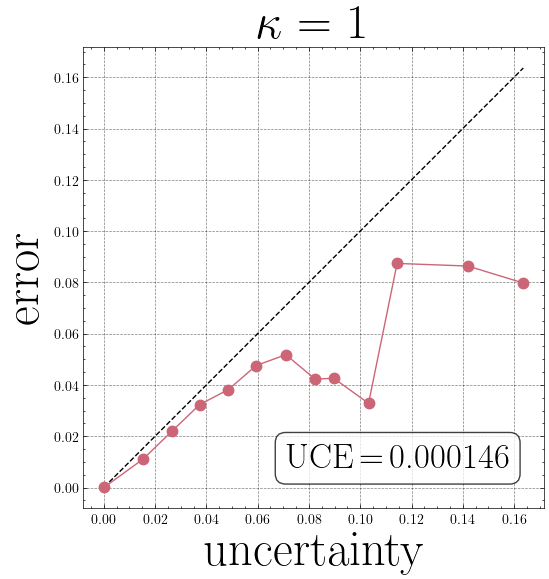

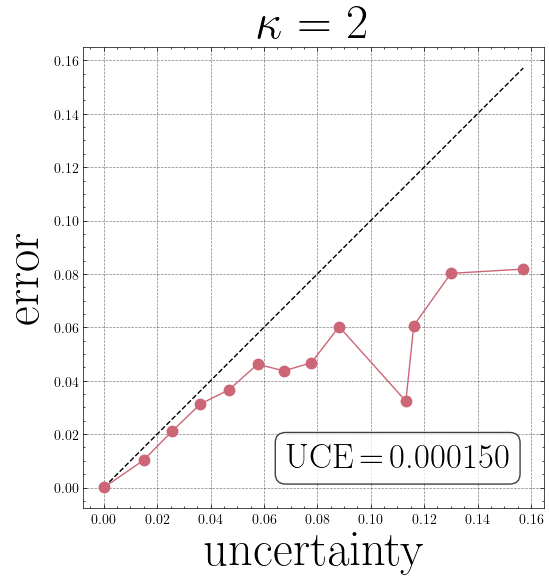

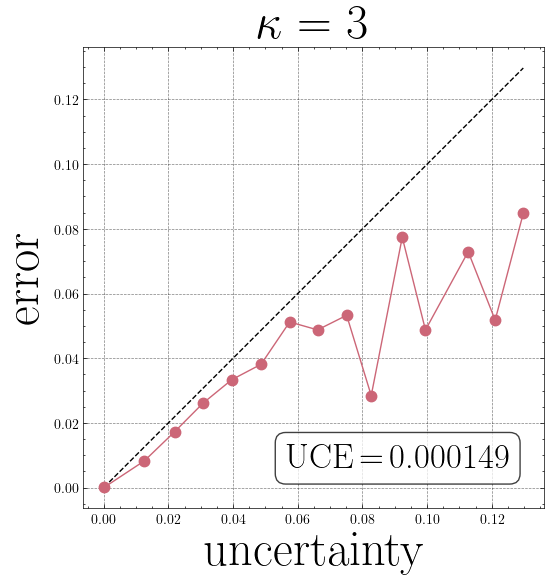

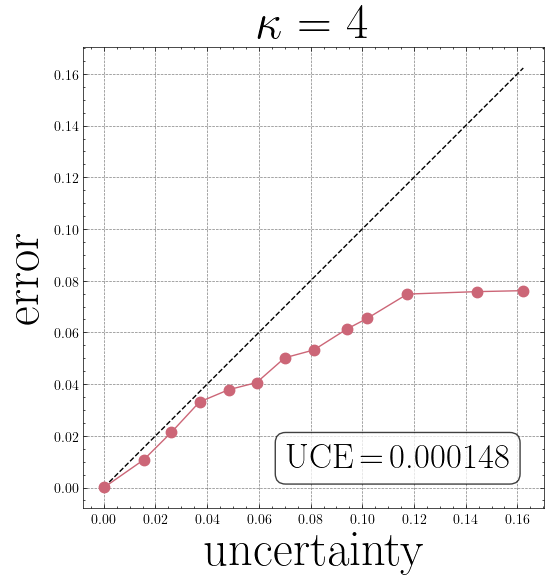

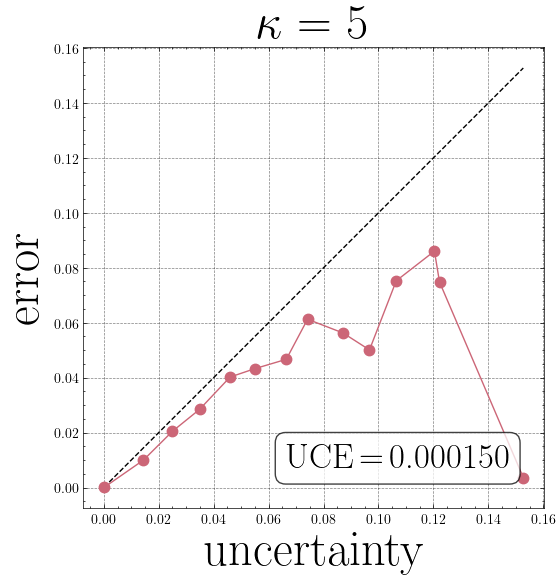

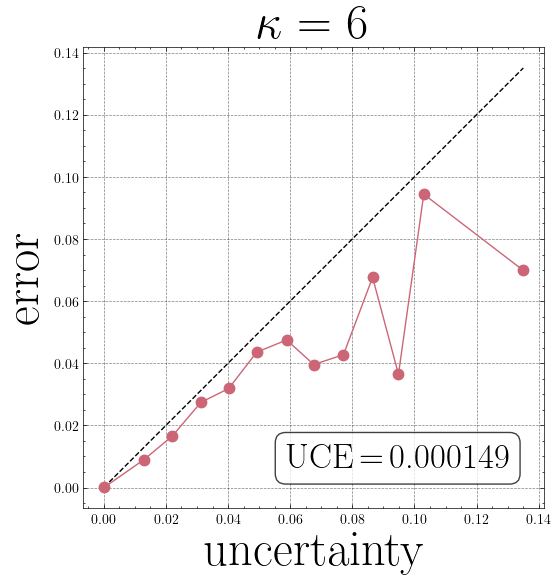

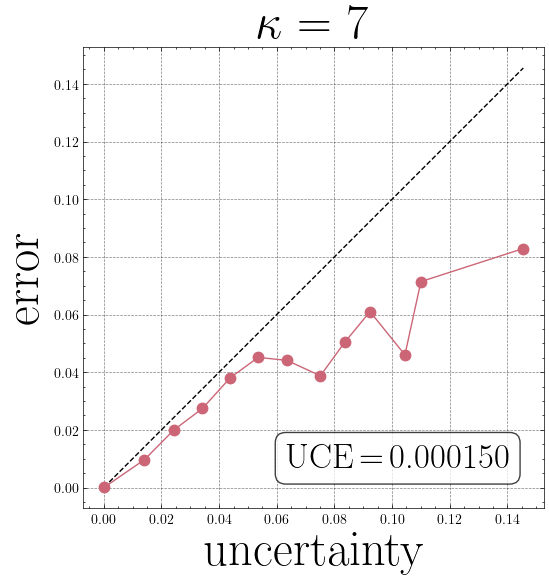

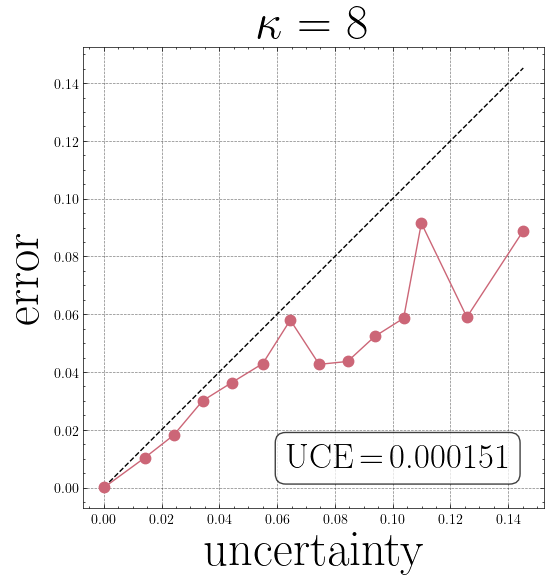

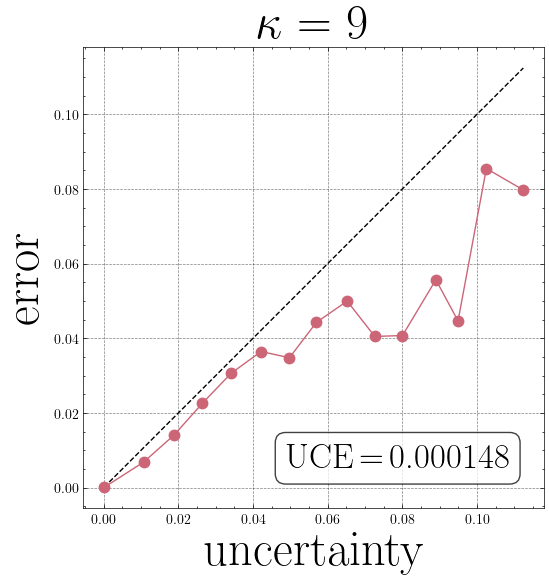

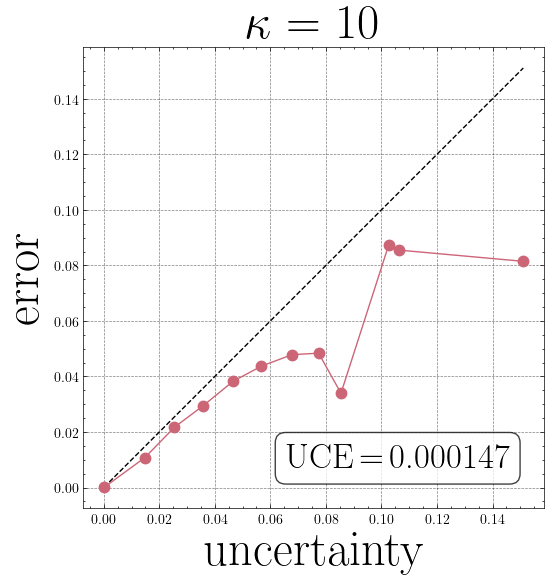

In [15]:
for i in range(0, 10):
    plot_uncert(errs_in_bin[i].detach().numpy(), avg_uncerts_in_bin[i].detach().numpy(), i=i + 1, uce=uces[i].item())

Averaged stochastic forward passes for an artificial and an experimental cell

In [19]:
real_cells = []
directory = '/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/DL-TFM-main/cells/cells/dspl'

for i, file in enumerate(os.listdir(directory)):
    filename = os.fsdecode(file)
    if filename.endswith(".mat"):
        real_cell = {}
        file = loadmat(directory+'/'+filename)
        real_cell['brdx'] = np.rot90(file['brdx'], 2)
        real_cell['brdy'] = np.rot90(file['brdy'], 2)
        real_cell['dspl'] = torch.tensor((1 / 200.2) * np.transpose(file['dspl']))
        real_cells.append(real_cell)

In [20]:
prob_vit_predictions = torch.zeros((2, 50, 4, 104, 104))
n_forward_passes = 50

for j in range(0, n_forward_passes):
    prob_vit_predictions[0, j, :, :, :] = inference_with_dropout(prob_vit, torch.tensor(test_sets['5'][0][np.newaxis, ...]).float())
    prob_vit_predictions[1, j, :, :, :] = inference_with_dropout(prob_vit, real_cells[0]['dspl'].unsqueeze(0).float())

In [21]:
predicted_mean = torch.mean(prob_vit_predictions[:, :, 0:2, :, :], dim=1)
total_unc = torch.mean(prob_vit_predictions[:, :, 0:2, :, :] ** 2 + prob_vit_predictions[:, :, 2:, :, :], dim=1) - predicted_mean ** 2
epistemic_unc = total_unc - (1 / n_forward_passes) * torch.sum(prob_vit_predictions[:, :, 2:, :, :], dim=1)
aleatoric_unc = total_unc - epistemic_unc

<IPython.core.display.Javascript object>


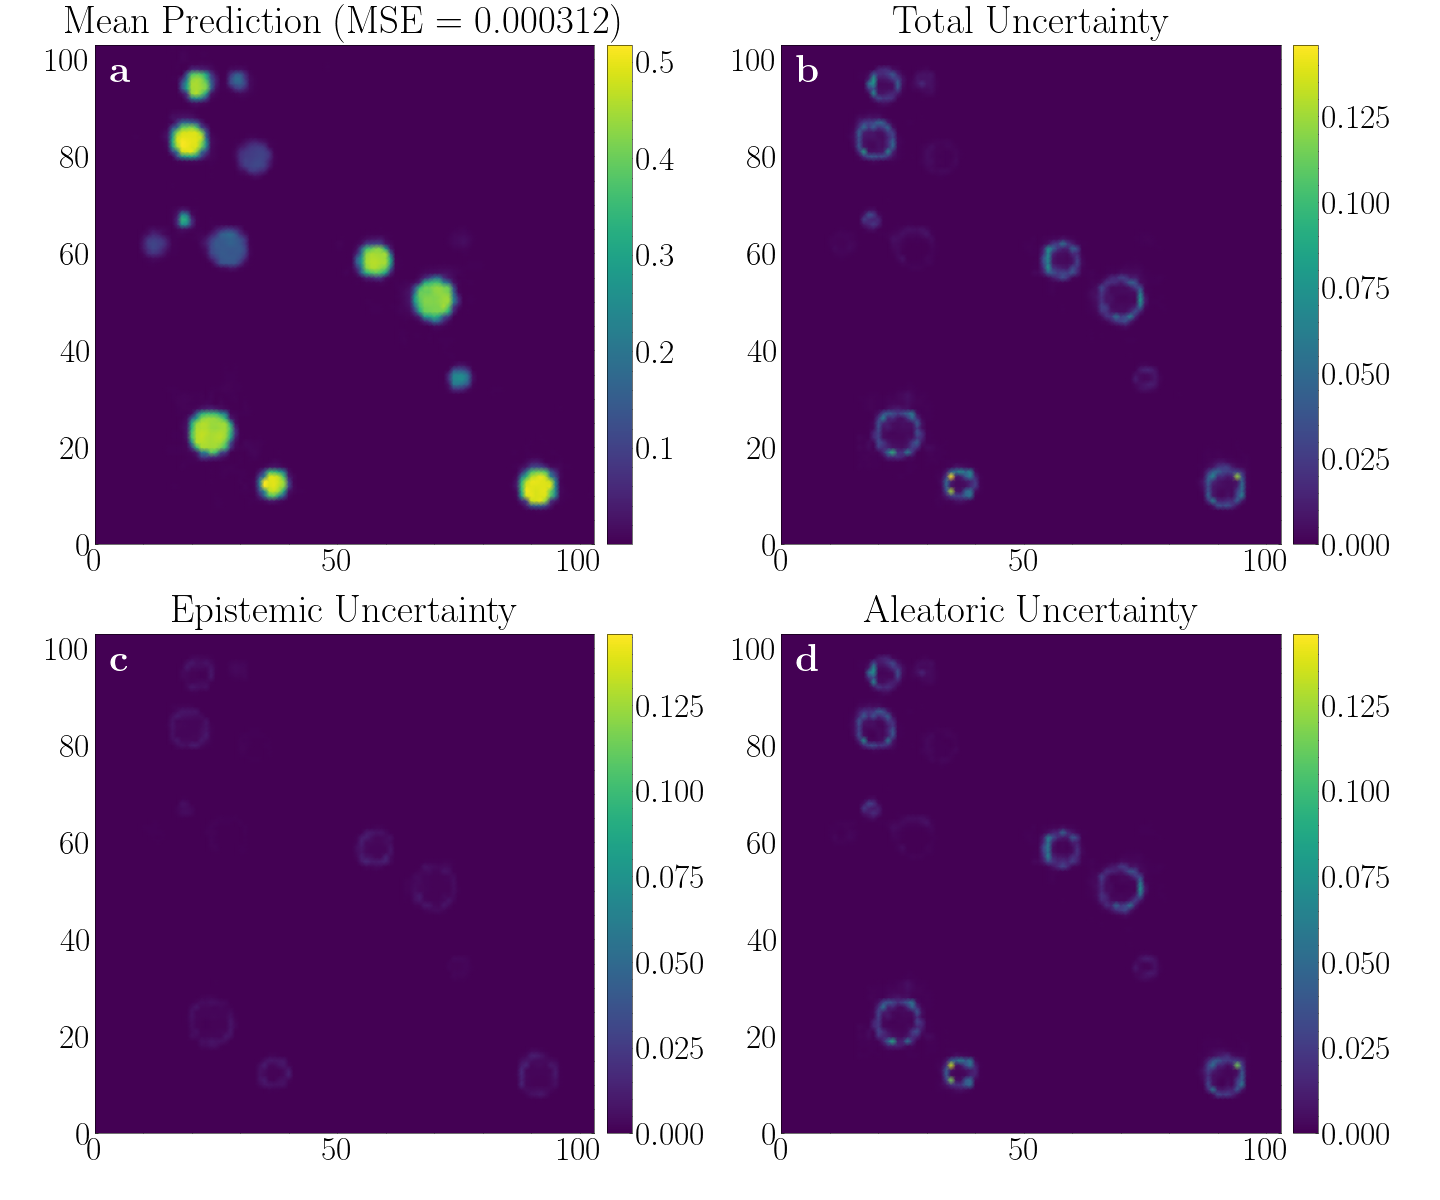

In [101]:
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

get_ipython().run_line_magic('matplotlib', 'notebook')
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 2, figsize=(18, 15))
fig.tight_layout(pad=3, w_pad=0, h_pad=4)

mse = torch.nn.MSELoss(reduction='mean')
err = mse(predicted_mean[0, :, :, :], Y_test[0, 0:2])

C = np.sqrt(predicted_mean[0, 0, :, :].detach().numpy() ** 2 + predicted_mean[0, 1, :, :].detach().numpy() ** 2)
im = axs[0, 0].pcolormesh(C, shading='gouraud')
colorbar = fig.colorbar(im, ax=axs[0, 0], pad=0.02)
axs[0, 0].set(adjustable='box', aspect='equal')
axs[0, 0].set_title(f'Mean Prediction (MSE ={err:9.6f})', pad=10, fontsize=35)
axs[0, 0].text(.03, .98, r'\textbf{a}', ha='left', va='top', transform=axs[0, 0].transAxes, color='white', fontsize=35, weight='bold')

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=np.max(np.sqrt(total_unc[0, 0, :, :].detach().numpy() ** 2 + total_unc[0, 1, :, :].detach().numpy() ** 2)))

C = np.sqrt(total_unc[0, 0, :, :].detach().numpy() ** 2 + total_unc[0, 1, :, :].detach().numpy() ** 2)
im = axs[0, 1].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[0, 1], pad=0.02, norm=norm)
axs[0, 1].set(adjustable='box', aspect='equal')
axs[0, 1].set_title('Total Uncertainty', pad=10, fontsize=35)
axs[0, 1].text(.03, .98, r'\textbf{b}', ha='left', va='top', transform=axs[0, 1].transAxes, color='white', fontsize=35, weight='bold')

C = np.sqrt(epistemic_unc[0, 0, :, :].detach().numpy() ** 2 + epistemic_unc[0, 1, :, :].detach().numpy() ** 2)
im = axs[1, 0].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1, 0], pad=0.02, norm=norm)
axs[1, 0].set(adjustable='box', aspect='equal')
axs[1, 0].set_title('Epistemic Uncertainty', pad=10, fontsize=35)
axs[1, 0].text(.03, .98, r'\textbf{c}', ha='left', va='top', transform=axs[1, 0].transAxes, color='white', fontsize=35, weight='bold')

C = np.sqrt(aleatoric_unc[0, 0, :, :].detach().numpy() ** 2 + aleatoric_unc[0, 1, :, :].detach().numpy() ** 2)
im = axs[1, 1].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1, 1], pad=0.02, norm=norm)
axs[1, 1].set(adjustable='box', aspect='equal')
axs[1, 1].set_title('Aleatoric Uncertainty', pad=10, fontsize=35)
axs[1, 1].text(.03, .98, r'\textbf{d}', ha='left', va='top', transform=axs[1, 1].transAxes, color='white', fontsize=35, weight='bold')

image_name = 'Uncertainty_artificial_cell_sq.jpeg'
fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=900)

In [100]:
C = torch.sqrt(epistemic_unc[0, 0, :, :] ** 2 + epistemic_unc[0, 1, :, :] ** 2)
mean_epistemic_magnitude = torch.mean(C)
print(mean_epistemic_magnitude)

tensor(0.000218, grad_fn=<MeanBackward0>)


In [45]:
C = torch.sqrt(aleatoric_unc[0, 0, :, :] ** 2 + aleatoric_unc[0, 1, :, :] ** 2)
mean_aleatoric_magnitude = torch.mean(C)
print(mean_aleatoric_magnitude)

tensor(0.000880, grad_fn=<MeanBackward0>)


In [46]:
C = torch.sqrt(total_unc[0, 0, :, :] ** 2 + total_unc[0, 1, :, :] ** 2)
mean_total_magnitude = torch.mean(C)
print(mean_total_magnitude)

tensor(0.001095, grad_fn=<MeanBackward0>)


In [102]:
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

get_ipython().run_line_magic('matplotlib', 'notebook')
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 2, figsize=(18, 15))
fig.tight_layout(pad=3, w_pad=0, h_pad=4)

C = np.sqrt(predicted_mean[1, 0, :, :].detach().numpy() ** 2 + predicted_mean[1, 1, :, :].detach().numpy() ** 2)
im = axs[0, 0].pcolormesh(C, shading='gouraud')
colorbar = fig.colorbar(im, ax=axs[0, 0], pad=0.02)
axs[0, 0].set(adjustable='box', aspect='equal')
axs[0, 0].plot(real_cells[0]['brdx'][0], real_cells[0]['brdy'][0], c='white')
axs[0, 0].set_title('Mean Prediction', pad=10, fontsize=35)
axs[0, 0].text(.03, .98, r'\textbf{e}', ha='left', va='top', transform=axs[0, 0].transAxes, color='white', fontsize=35, weight='bold')

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=np.max(np.sqrt(total_unc[1, 0, :, :].detach().numpy() ** 2 + total_unc[1, 1, :, :].detach().numpy() ** 2)))

C = np.sqrt(total_unc[1, 0, :, :].detach().numpy() ** 2 + total_unc[1, 1, :, :].detach().numpy() ** 2)
im = axs[0, 1].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[0, 1], pad=0.02, norm=norm)
axs[0, 1].set(adjustable='box', aspect='equal')
axs[0, 1].plot(real_cells[0]['brdx'][0], real_cells[0]['brdy'][0], c='white')
axs[0, 1].set_title('Total Uncertainty', pad=10, fontsize=35)
axs[0, 1].text(.03, .98, r'\textbf{f}', ha='left', va='top', transform=axs[0, 1].transAxes, color='white', fontsize=35, weight='bold')

C = np.sqrt(epistemic_unc[1, 0, :, :].detach().numpy() ** 2 + epistemic_unc[1, 1, :, :].detach().numpy() ** 2)
im = axs[1, 0].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1, 0], pad=0.02, norm=norm)
axs[1, 0].set(adjustable='box', aspect='equal')
axs[1, 0].plot(real_cells[0]['brdx'][0], real_cells[0]['brdy'][0], c='white')
axs[1, 0].set_title('Epistemic Uncertainty', pad=10, fontsize=35)
axs[1, 0].text(.03, .98, r'\textbf{g}', ha='left', va='top', transform=axs[1, 0].transAxes, color='white', fontsize=35, weight='bold')

C = np.sqrt(aleatoric_unc[1, 0, :, :].detach().numpy() ** 2 + aleatoric_unc[1, 1, :, :].detach().numpy() ** 2)
im = axs[1, 1].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1, 1], pad=0.02, norm=norm)
axs[1, 1].set(adjustable='box', aspect='equal')
axs[1, 1].plot(real_cells[0]['brdx'][0], real_cells[0]['brdy'][0], c='white')
axs[1, 1].set_title('Aleatoric Uncertainty', pad=10, fontsize=35)
axs[1, 1].text(.03, .98, r'\textbf{h}', ha='left', va='top', transform=axs[1, 1].transAxes, color='white', fontsize=35, weight='bold')

image_name = 'Uncertainty_real_cell_sq.jpeg'
fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=900)

<IPython.core.display.Javascript object>

In [47]:
C = torch.sqrt(epistemic_unc[1, 0, :, :] ** 2 + epistemic_unc[1, 1, :, :] ** 2)
mean_epistemic_magnitude = torch.mean(C)
print(mean_epistemic_magnitude)

tensor(1.029601e-05, grad_fn=<MeanBackward0>)


In [48]:
C = torch.sqrt(aleatoric_unc[1, 0, :, :] ** 2 + aleatoric_unc[1, 1, :, :] ** 2)
mean_aleatoric_magnitude = torch.mean(C)
print(mean_aleatoric_magnitude)

tensor(4.064642e-05, grad_fn=<MeanBackward0>)


In [49]:
C = torch.sqrt(total_unc[1, 0, :, :] ** 2 + total_unc[1, 1, :, :] ** 2)
mean_total_magnitude = torch.mean(C)
print(mean_total_magnitude)

tensor(5.078725e-05, grad_fn=<MeanBackward0>)
